KEGG pathways overlap

# Group Member - [Christian Rizza]

## Question 1:
The biggest challenge for me was limiting the scope of what feature I wanted to implement. KEGG is a very large database making it difficult to ask specific questions because of how much information you have access to.

## Question 2:
What did you learn while working on this project?

I learned about the structure of the KEGG database and what type of information you can obtain from the API to use in a I also learned how to query from KEGG and ways to enhance the efficiency of this process. nalysis.

## Question 3:
If you had more time on the project, what other question(s) would you like to answer?

I would have liked to better understand, for all of the diseases that had high gene overlap, what metabolic, biological, and molecular processes are they involved in.
t file.

In [4]:
#Part 1: Map/merge the information by PATHWAY_ID and GENE_ID.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import networkx as nx
from itertools import combinations
import requests
from concurrent.futures import ThreadPoolExecutor

#file names
gene_file = "gene.txt"
human_file = "human.txt"

#load in files
gene_data = pd.read_csv(gene_file, sep="\t", header=None, names=["GENE_ID", "PATHWAY_ID"])
human_data = pd.read_csv(human_file, sep="\t", header=None, names=["PATHWAY_ID", "PATHWAY_NAME"])
print(gene_data.head(), human_data.head())


     GENE_ID     PATHWAY_ID
0  hsa:10327  path:hsa00010
1    hsa:124  path:hsa00010
2    hsa:125  path:hsa00010
3    hsa:126  path:hsa00010
4    hsa:127  path:hsa00010   PATHWAY_ID                                       PATHWAY_NAME
0   hsa01100          Metabolic pathways - Homo sapiens (human)
1   hsa01200           Carbon metabolism - Homo sapiens (human)
2   hsa01210  2-Oxocarboxylic acid metabolism - Homo sapiens...
3   hsa01212       Fatty acid metabolism - Homo sapiens (human)
4   hsa01230  Biosynthesis of amino acids - Homo sapiens (hu...


In [5]:
#remove 'path:' from gene_data
gene_data["PATHWAY_ID"] = gene_data["PATHWAY_ID"].str.replace("path:", "")

#Merge
merged_data = pd.merge(gene_data, human_data, on="PATHWAY_ID", how="inner")
print(merged_data.head())

rows, columns = merged_data.shape

print("Number of rows:", rows)
print("Number of columns:", columns)

     GENE_ID PATHWAY_ID                                       PATHWAY_NAME
0  hsa:10327   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
1    hsa:124   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
2    hsa:125   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
3    hsa:126   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
4    hsa:127   hsa00010  Glycolysis / Gluconeogenesis - Homo sapiens (h...
Number of rows: 37470
Number of columns: 3


In [6]:
#Part 2/3:Compute the number of overlapping genes between every 2 pathways & Save as KEGG_crosstalk.csv
from itertools import combinations
pathway_to_genes = (
    merged_data.groupby("PATHWAY_ID")["GENE_ID"]
    .apply(set) 
    .to_dict()
)

#Map Pathway names
pathway_to_name = (
    merged_data.groupby("PATHWAY_ID")["PATHWAY_NAME"]
    .first()
    .to_dict()
)

results = []

#Compute Overlaps
for (path1, genes1), (path2, genes2) in combinations(pathway_to_genes.items(), 2):
    overlap = genes1.intersection(genes2)
    if overlap:  # Only include pairs with overlaps
        results.append({
            "PATHWAY_ID1": path1,
            "PATHWAY_NAME1": pathway_to_name[path1],
            "PATHWAY_ID2": path2,
            "PATHWAY_NAME2": pathway_to_name[path2],
            "NUMBER_OF_OVERLAPPING_GENES": len(overlap),
            "LIST_OF_OVERLAPPING_GENES": ";".join(sorted(overlap))
        })

#turn it into a dataframe
results_df = pd.DataFrame(results)

#Descending Order
results_df = results_df.sort_values(by="NUMBER_OF_OVERLAPPING_GENES", ascending=False)

#Save CSV file
results_df.to_csv("KEGG_crosstalk.csv", index=False)

print(results_df.head())

      PATHWAY_ID1                                      PATHWAY_NAME1  \
19381    hsa05010           Alzheimer disease - Homo sapiens (human)   
19522    hsa05014  Amyotrophic lateral sclerosis - Homo sapiens (...   
19597    hsa05016          Huntington disease - Homo sapiens (human)   
19460    hsa05012           Parkinson disease - Homo sapiens (human)   
19519    hsa05014  Amyotrophic lateral sclerosis - Homo sapiens (...   

      PATHWAY_ID2                                      PATHWAY_NAME2  \
19381    hsa05022  Pathways of neurodegeneration - multiple disea...   
19522    hsa05022  Pathways of neurodegeneration - multiple disea...   
19597    hsa05022  Pathways of neurodegeneration - multiple disea...   
19460    hsa05022  Pathways of neurodegeneration - multiple disea...   
19519    hsa05016          Huntington disease - Homo sapiens (human)   

       NUMBER_OF_OVERLAPPING_GENES  \
19381                          339   
19522                          300   
19597               

In [7]:
# Part 4 Compute a rank of the genes based on how many pathways they appear on and save it to a file
# Compute gene ranks based on the number of pathways they appear in
gene_to_pathways = (
    merged_data.groupby("GENE_ID")["PATHWAY_ID"]
    .apply(set)
    .to_dict()
)

# Create a DataFrame for gene ranks
gene_ranks = [
    {"GENE_ID": gene, "NUMBER_OF_PATHWAYS": len(pathways)}
    for gene, pathways in gene_to_pathways.items()
]

# Convert to DataFrame and sort by NUMBER_OF_PATHWAYS
gene_ranks_df = pd.DataFrame(gene_ranks).sort_values(by="NUMBER_OF_PATHWAYS", ascending=False)

# Save to a CSV file
gene_ranks_df.to_csv("KEGG_gene_ranks.csv", index=False)

print(gene_ranks_df.head())

       GENE_ID  NUMBER_OF_PATHWAYS
5742  hsa:5595                 118
5741  hsa:5594                 118
5233  hsa:5290                 106
5236  hsa:5293                 106
5234  hsa:5291                 106


In [8]:
# 5. Retrieve a set of the pathways the top 3 genes appear on
# Create a dictionary mapping PATHWAY_ID to PATHWAY_NAME so that pathway names can be assigned to the IDs
pathway_name_dict = merged_data.drop_duplicates(subset="PATHWAY_ID")[["PATHWAY_ID", "PATHWAY_NAME"]]
pathway_name_dict = pathway_name_dict.set_index("PATHWAY_ID")["PATHWAY_NAME"].to_dict()

# Retrieve pathways for top 3 genes
top_genes = gene_ranks_df.head(3)["GENE_ID"].tolist()  # Ensure top_genes is a list

top_genes_pathways_ids = {}  # For storing pathway IDs
top_genes_pathways_names = {}  # For storing pathway names

for gene in top_genes:
    pathways = merged_data[merged_data["GENE_ID"] == gene]["PATHWAY_ID"].unique()
    top_genes_pathways_ids[gene] = set(pathways)
    
    # Map the pathway IDs to names using pathway_name_dict
    pathway_names = [pathway_name_dict.get(pathway_id, "Unknown pathway") for pathway_id in pathways]
    top_genes_pathways_names[gene] = set(pathway_names)

# Output results
print("Top genes and their pathway IDs:")
print(top_genes_pathways_ids)

print("\nTop genes and their pathway names:")
print(top_genes_pathways_names)



Top genes and their pathway IDs:
{'hsa:5595': {'hsa04151', 'hsa04650', 'hsa04371', 'hsa05219', 'hsa04350', 'hsa05205', 'hsa04620', 'hsa04726', 'hsa04935', 'hsa04929', 'hsa05022', 'hsa04662', 'hsa04062', 'hsa04520', 'hsa04926', 'hsa05221', 'hsa04611', 'hsa04659', 'hsa04015', 'hsa04370', 'hsa05167', 'hsa05214', 'hsa04014', 'hsa05213', 'hsa05034', 'hsa04625', 'hsa05010', 'hsa04915', 'hsa04066', 'hsa04022', 'hsa05020', 'hsa04148', 'hsa01521', 'hsa04657', 'hsa04024', 'hsa04713', 'hsa05170', 'hsa01522', 'hsa04540', 'hsa04810', 'hsa04668', 'hsa05161', 'hsa04658', 'hsa04510', 'hsa04621', 'hsa05152', 'hsa01524', 'hsa04068', 'hsa04150', 'hsa05212', 'hsa04613', 'hsa05208', 'hsa05145', 'hsa04960', 'hsa04930', 'hsa04666', 'hsa05142', 'hsa05226', 'hsa04140', 'hsa05200', 'hsa05166', 'hsa05417', 'hsa05206', 'hsa04910', 'hsa04730', 'hsa04380', 'hsa04933', 'hsa04916', 'hsa05135', 'hsa04722', 'hsa04664', 'hsa04725', 'hsa04071', 'hsa05224', 'hsa05211', 'hsa05131', 'hsa05133', 'hsa05230', 'hsa04660', 'hsa0

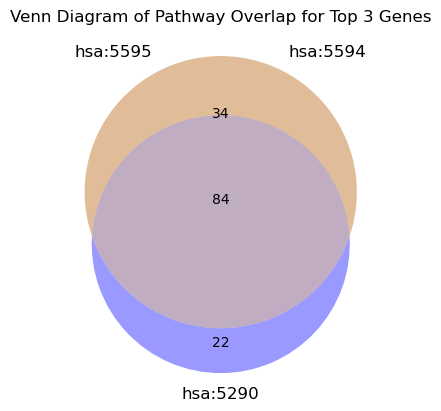

In [9]:
# Part 6: Venn Diagram for Top 3 Genes
# Prepare data for Venn diagram
top_genes_pathways_ids = {
    gene: set(merged_data[merged_data["GENE_ID"] == gene]["PATHWAY_ID"].unique())
    for gene in top_genes
}

# Extract pathway sets for Venn diagram
venn_sets = list(top_genes_pathways_ids.values())

# Create the Venn diagram
venn = venn3(
    [venn_sets[0], venn_sets[1], venn_sets[2]],
    top_genes
)

# Add title and display
plt.title("Venn Diagram of Pathway Overlap for Top 3 Genes")
plt.show()


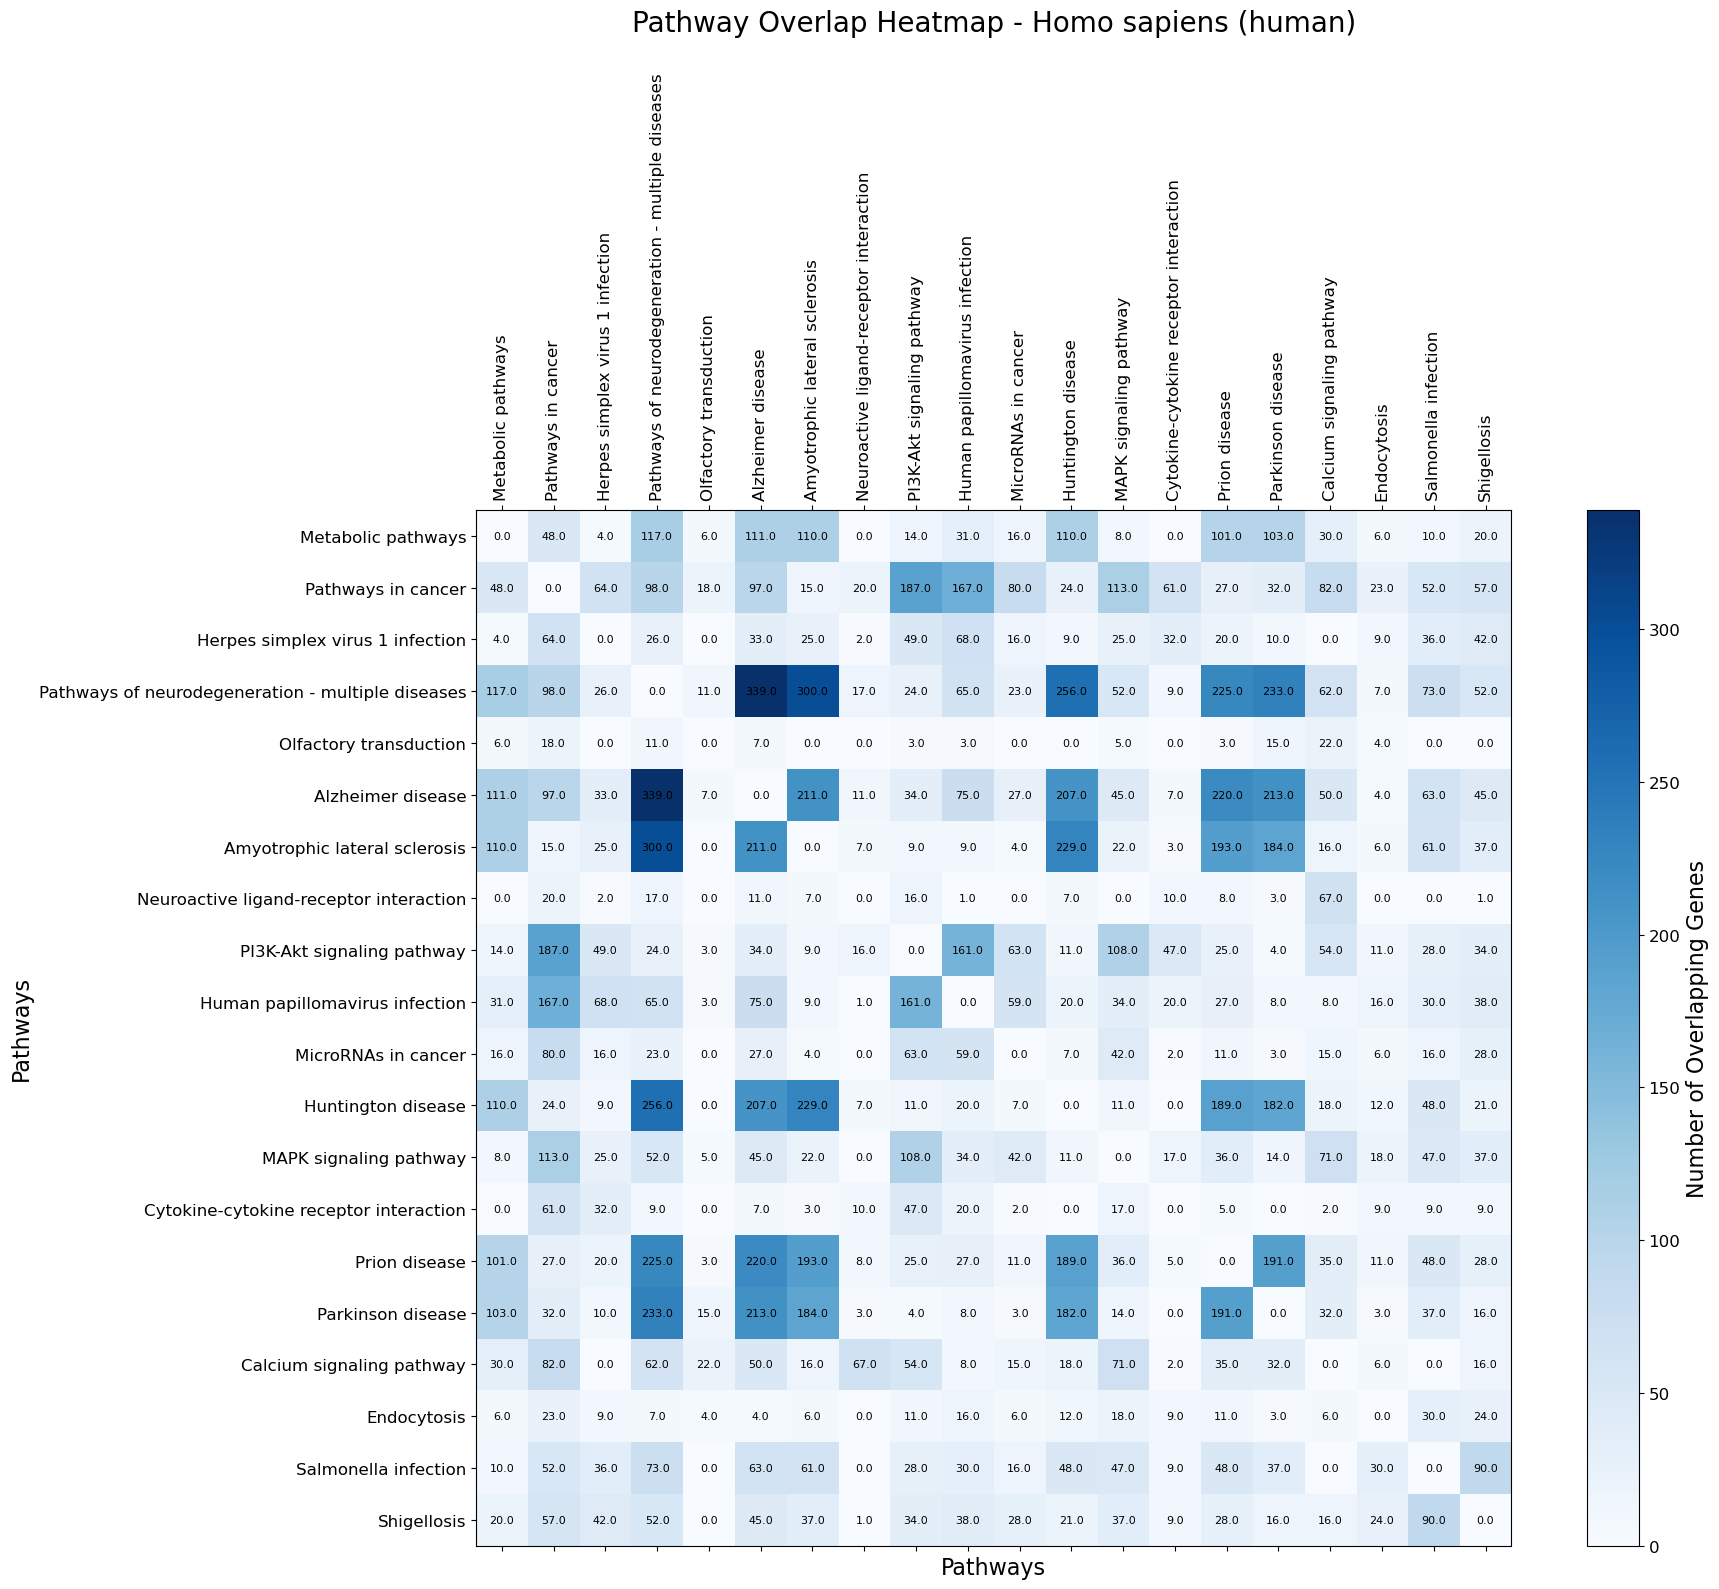

In [10]:
# Feature 1: Pathway Overlap Heatmap 
# This feature visually represents the overlap of genes between pathways using a heatmap. The goal is to uncover relationships between pathways based on their shared genetic content. By highlighting these overlaps, the heatmap can reveal functional modules, pathway interactions, or redundancies within biological systems.

# Select the top N pathways with the most genes
top_pathways = sorted(pathway_to_genes.keys(), key=lambda x: len(pathway_to_genes[x]), reverse=True)[:20]

# Create a reduced overlap matrix for the top pathways
reduced_overlap_matrix = np.zeros((len(top_pathways), len(top_pathways)))

# Compute overlaps for the selected pathways
for i, path1 in enumerate(top_pathways):
    for j, path2 in enumerate(top_pathways):
        if i < j:
            overlap = len(pathway_to_genes[path1].intersection(pathway_to_genes[path2]))
            reduced_overlap_matrix[i, j] = overlap
            reduced_overlap_matrix[j, i] = overlap

# Remove "- Homo sapiens (human)" from pathway labels
pathway_labels = [pathway_to_name[pathway].replace(" - Homo sapiens (human)", "") for pathway in top_pathways]

# Heatmap Visualization
fig, ax = plt.subplots(figsize=(20, 16))  # Increase figure size (width x height)
cax = ax.matshow(reduced_overlap_matrix, cmap="Blues")

# Add color bar with larger font size
cbar = plt.colorbar(cax, label="Number of Overlapping Genes")
cbar.ax.tick_params(labelsize=12)  # Adjust color bar font size
cbar.set_label("Number of Overlapping Genes", fontsize=16)

# Add labels to axes with larger font sizes and vertical x-axis labels
ax.set_xticks(np.arange(len(pathway_labels)))
ax.set_yticks(np.arange(len(pathway_labels)))
ax.set_xticklabels(pathway_labels, rotation=90, ha="center", fontsize=12)  # Vertical alignment
ax.set_yticklabels(pathway_labels, fontsize=12)

# Annotate all cells, including zeros
for i in range(reduced_overlap_matrix.shape[0]):
    for j in range(reduced_overlap_matrix.shape[1]):
        ax.text(
            j, i, str(reduced_overlap_matrix[i, j]),  # Annotate with the value
            ha="center", va="center", color="black", fontsize=8
        )

# Add title and axis labels
plt.title("Pathway Overlap Heatmap - Homo sapiens (human)", pad=30, fontsize=20)
plt.xlabel("Pathways", fontsize=16)
plt.ylabel("Pathways", fontsize=16)

plt.tight_layout()
plt.show()





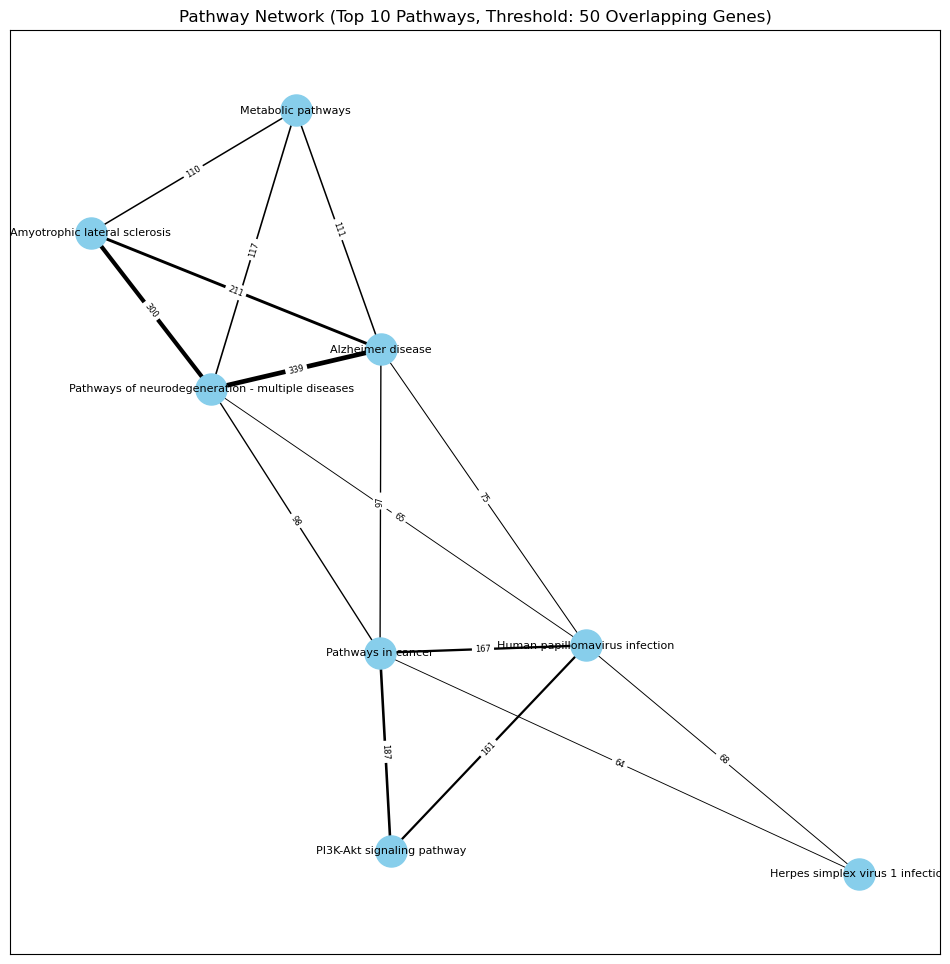

In [11]:
### Feature 2: Network Visualization of Top N number of pathways with a threshold of 50 genes at minimum.
### Each Node represents a pathway and the edges represent the number of genes. Edges are weighted based on the number
### of genes they represent. The greater the number of edges connecting a node shows more gene overlap suggesting 
### A higher degree of similarity. The feature more explicitly defines the relationship linkihng each pathway in comparison to the heatmap.
### ChatGPT was used in implementation of this feature.


# Load and Clean Data
def load_data_clean_names(gene_file, human_file):
    """
    Load data from files and clean pathway names by removing ' - Homo sapiens (human)'.
    """
    gene_data = pd.read_csv(gene_file, sep="\t", header=None, names=["GENE_ID", "PATHWAY_ID"])
    human_data = pd.read_csv(human_file, sep="\t", header=None, names=["PATHWAY_ID", "PATHWAY_NAME"])
    # Clean PATHWAY_ID and PATHWAY_NAME
    gene_data["PATHWAY_ID"] = gene_data["PATHWAY_ID"].str.replace("path:", "", regex=False)
    human_data["PATHWAY_NAME"] = human_data["PATHWAY_NAME"].str.replace(" - Homo sapiens \\(human\\)", "", regex=True)
    # Merge datasets
    return pd.merge(gene_data, human_data, on="PATHWAY_ID", how="inner")

# Enrichment Analysis with Cleaned PATHWAY_NAME
def simplified_enrichment_analysis_with_names(merged_data):
    """
    Perform enrichment analysis and return pathway overlaps using PATHWAY_NAME.
    """
    pathway_to_genes = merged_data.groupby("PATHWAY_NAME")["GENE_ID"].apply(set).to_dict()
    results = []
    for (path1, genes1), (path2, genes2) in combinations(pathway_to_genes.items(), 2):
        overlap = genes1.intersection(genes2)
        if overlap:
            results.append({
                "PATHWAY_NAME1": path1,
                "PATHWAY_NAME2": path2,
                "NUMBER_OF_OVERLAPPING_GENES": len(overlap),
                "OVERLAPPING_GENES": ";".join(overlap)
            })
    return pd.DataFrame(results)

# Network Visualization with Weighted Edges and Cleaned PATHWAY_NAME
def simplified_network_with_weights(overlap_df, merged_data, max_nodes, threshold=0):
    """
    Create a simplified network visualization using cleaned PATHWAY_NAME, with edge weights based on the number of overlapping genes.
    """
    # Filter by threshold
    filtered_df = overlap_df[overlap_df["NUMBER_OF_OVERLAPPING_GENES"] >= threshold]
    
    # Count the number of genes per pathway to prioritize nodes with higher gene content
    pathway_gene_count = (
        merged_data.groupby("PATHWAY_NAME")["GENE_ID"]
        .count()
        .sort_values(ascending=False)
    )
    
    # Select top pathways based on gene count
    top_pathways = pathway_gene_count.head(max_nodes).index
    filtered_df = filtered_df[
        filtered_df["PATHWAY_NAME1"].isin(top_pathways) & filtered_df["PATHWAY_NAME2"].isin(top_pathways)
    ]
    
    # Create the graph
    G = nx.Graph()
    for _, row in filtered_df.iterrows():
        G.add_edge(
            row["PATHWAY_NAME1"],
            row["PATHWAY_NAME2"],
            weight=row["NUMBER_OF_OVERLAPPING_GENES"]  # Add edge weight
        )
    
    # Visualize the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
    
    # Draw edges with weights affecting thickness
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w / 100 for w in weights])  # Scale weights for better visualization
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # Add edge labels to show weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(f"Pathway Network (Top {max_nodes} Pathways, Threshold: {threshold} Overlapping Genes)")
    plt.show()

# Example Usage
# Replace with your actual file paths
gene_file = "gene.txt"  # Gene file path
human_file = "human.txt"  # Human pathway file path

# Load and clean the data
merged_data_cleaned = load_data_clean_names(gene_file, human_file)

# Perform enrichment analysis with cleaned PATHWAY_NAME
overlap_df_with_names = simplified_enrichment_analysis_with_names(merged_data_cleaned)

# Generate network visualization with weights
max_nodes = 10  # Limit to the top 20 pathways
threshold = 50  # Set the minimum number of overlapping genes to show a connection
simplified_network_with_weights(overlap_df_with_names, merged_data_cleaned, max_nodes, threshold)



                                             Pathway 1  \
42   Pathways of neurodegeneration - multiple diseases   
43   Pathways of neurodegeneration - multiple diseases   
48   Pathways of neurodegeneration - multiple diseases   
51   Pathways of neurodegeneration - multiple diseases   
69                       Amyotrophic lateral sclerosis   
..                                                 ...   
97                                 MicroRNAs in cancer   
85                          PI3K-Akt signaling pathway   
80                          PI3K-Akt signaling pathway   
58                                   Alzheimer disease   
101                                 Huntington disease   

                                   Pathway 2  Overlap Count  
42                         Alzheimer disease          339.0  
43             Amyotrophic lateral sclerosis          300.0  
48                        Huntington disease          256.0  
51                         Parkinson disease          2

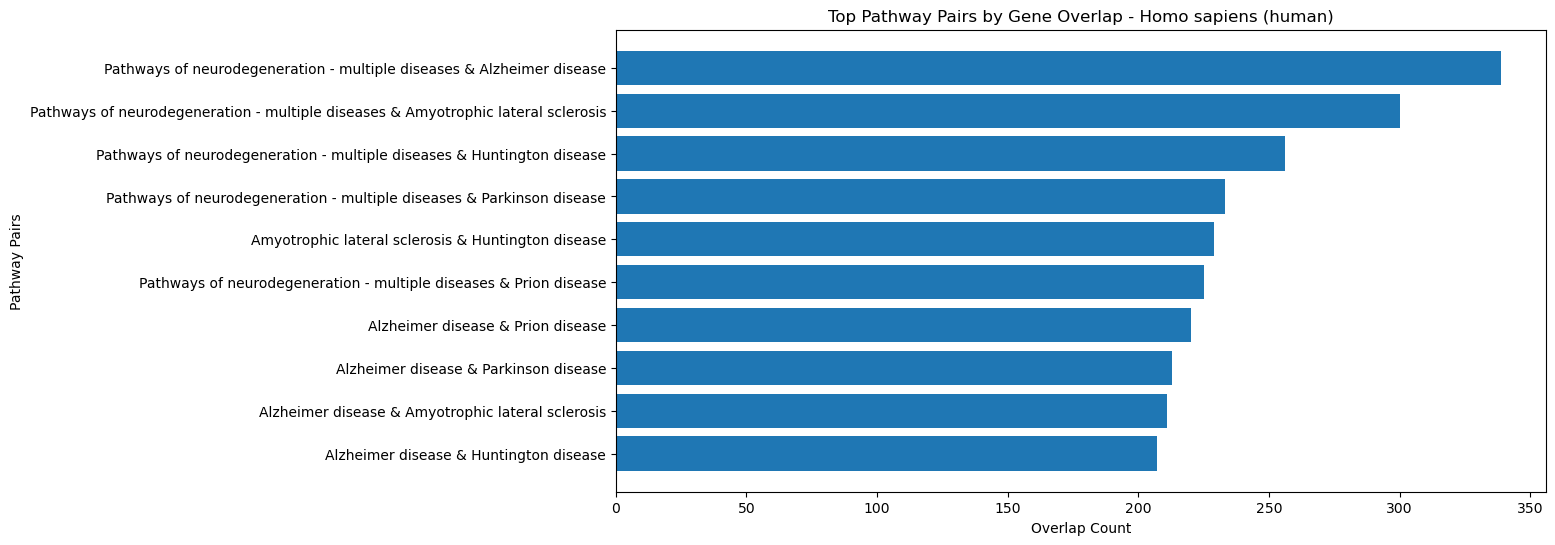

In [12]:
### Feature 3: Barplot identifying gene overlap between pairs of pathwys in order to identify more specific pathway-pathway gene similarities. ChatGPT was used in implementation of this feature.
# Find pathway pairs with high overlap
threshold = 10  # Minimum number of overlapping genes
high_overlap_pairs = [
    (pathway_labels[i], pathway_labels[j], reduced_overlap_matrix[i, j])
    for i in range(len(top_pathways))
    for j in range(len(top_pathways))
    if i < j and reduced_overlap_matrix[i, j] > threshold
]

# Create a DataFrame for visualization
high_overlap_df = pd.DataFrame(high_overlap_pairs, columns=["Pathway 1", "Pathway 2", "Overlap Count"])
print(high_overlap_df.sort_values(by="Overlap Count", ascending=False))

# Sort and get top 10 overlaps
top_pairs = high_overlap_df.sort_values(by="Overlap Count", ascending=False).head(10)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(
    [f"{row['Pathway 1']} & {row['Pathway 2']}" for _, row in top_pairs.iterrows()],
    top_pairs["Overlap Count"]
)
plt.xlabel("Overlap Count")
plt.ylabel("Pathway Pairs")
plt.title("Top Pathway Pairs by Gene Overlap - Homo sapiens (human)")
plt.gca().invert_yaxis()  # Reverse the y-axis for readability
plt.show()


Shared Genes Across Pathways:
{'hsa:4704', 'hsa:5707', 'hsa:517', 'hsa:4538', 'hsa:5688', 'hsa:515', 'hsa:4697', 'hsa:9861', 'hsa:54205', 'hsa:124908013', 'hsa:516', 'hsa:514', 'hsa:5719', 'hsa:107984365', 'hsa:3710', 'hsa:9821', 'hsa:637', 'hsa:4715', 'hsa:55967', 'hsa:4731', 'hsa:5700', 'hsa:55626', 'hsa:317', 'hsa:5689', 'hsa:4714', 'hsa:842', 'hsa:7186', 'hsa:51807', 'hsa:7416', 'hsa:4509', 'hsa:84617', 'hsa:5701', 'hsa:498', 'hsa:1347', 'hsa:3799', 'hsa:9377', 'hsa:4719', 'hsa:170712', 'hsa:4724', 'hsa:64837', 'hsa:4718', 'hsa:4710', 'hsa:84790', 'hsa:347688', 'hsa:4513', 'hsa:124908041', 'hsa:81027', 'hsa:5690', 'hsa:4514', 'hsa:10382', 'hsa:5532', 'hsa:4696', 'hsa:10383', 'hsa:4843', 'hsa:10975', 'hsa:6392', 'hsa:1965', 'hsa:5708', 'hsa:3831', 'hsa:4720', 'hsa:2475', 'hsa:60673', 'hsa:4536', 'hsa:347733', 'hsa:5694', 'hsa:4541', 'hsa:4712', 'hsa:5692', 'hsa:8408', 'hsa:572', 'hsa:8678', 'hsa:5685', 'hsa:6390', 'hsa:2903', 'hsa:4728', 'hsa:7388', 'hsa:5693', 'hsa:90550', 'hsa:472

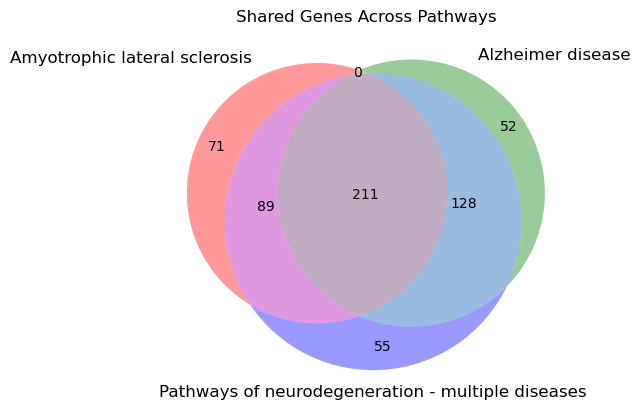

In [13]:
### Feature 4 - Visualizing the number of genes that are unique to each pathway among top overlapping pathways in the dataset. While previous features focused on pairs visualizing multiple ways to look at overlaps,
### we still do not which genes are unique to each of the diseases with high overlap. Unique genes might inform us on distinguishing features between each disease process. ChatGPT was used in implementation of this feature.


def get_shared_genes(pathway_names, merged_data):
    """
    Get shared genes for a given set of pathway names.

    Parameters:
        pathway_names (list): List of pathway names to compare.
        merged_data (pd.DataFrame): The merged data containing GENE_ID and PATHWAY_NAME.

    Returns:
        set: A set of shared genes across the specified pathways.
        dict: A dictionary of genes per pathway.
    """
    # Create a mapping of pathway names to their associated genes
    pathway_to_genes = merged_data.groupby("PATHWAY_NAME")["GENE_ID"].apply(set).to_dict()

    # Extract gene sets for the specified pathways
    pathway_genes = {name: pathway_to_genes.get(name, set()) for name in pathway_names}

    # Compute the intersection of genes
    shared_genes = set.intersection(*pathway_genes.values())

    return shared_genes, pathway_genes

# Specify the pathways of interest
pathways_of_interest = [
    "Amyotrophic lateral sclerosis",
    "Alzheimer disease",
    "Pathways of neurodegeneration - multiple diseases"
]

# Get shared genes and genes per pathway
shared_genes, pathway_genes = get_shared_genes(pathways_of_interest, merged_data_cleaned)

# Output results
print("Shared Genes Across Pathways:")
print(shared_genes)
print("\nGenes per Pathway:")
for pathway, genes in pathway_genes.items():
    print(f"{pathway}: {genes}")

# Optional: Save results to a file
shared_genes_df = pd.DataFrame({
    "Gene": list(shared_genes),
    "Pathways": ["; ".join(pathways_of_interest)] * len(shared_genes)
})
shared_genes_df.to_csv("shared_genes_across_pathways.csv", index=False)

# Step 2: Venn Diagram Visualization for Multiple Pathways
def plot_venn_diagram(pathway_genes, pathway_names):
    """
    Plot a Venn diagram for the specified pathways.
    
    Parameters:
        pathway_genes (dict): Dictionary of genes per pathway.
        pathway_names (list): Names of the pathways to include in the Venn diagram.
    """
    # Extract gene sets for the pathways
    sets = [pathway_genes[pathway] for pathway in pathway_names]
    
    # Create the Venn diagram
    venn = venn3(
        subsets=sets,
        set_labels=pathway_names
    )
    
    # Add title and display
    plt.title("Shared Genes Across Pathways")
    plt.show()

# Plot the Venn diagram
plot_venn_diagram(pathway_genes, pathways_of_interest)


In [26]:
# Feature 4, part 2. Function to fetch gene IDs that are overlapping amongst all the associated diseases in part 1. Part 2 queries KEGG API for these IDs in batches from KEGG API and returns gene names, drug ids, and drug names
# for the Gene IDs in part 1. ChatGPT was used in the implementation of this feature. 

def fetch_gene_names_batch(gene_ids):
    base_url = "http://rest.kegg.jp/list/"
    batch_size = 10  # Number of IDs per batch
    gene_names = {}

    for i in range(0, len(gene_ids), batch_size):
        batch = "+".join(gene_ids[i:i+batch_size])
        response = requests.get(base_url + batch)
        if response.status_code == 200:
            lines = response.text.strip().split("\n")
            for line in lines:
                parts = line.split("\t")
                if len(parts) >= 2:
                    gene_names[parts[0]] = parts[1]
        else:
            print(f"Failed to fetch gene names for batch: {batch}")
    
    return gene_names

# Function to fetch drug details in parallel 
def fetch_drug_details_parallel(drug_ids):
    base_url = "http://rest.kegg.jp/get/"
    drug_names = {}

    def fetch_single_drug(drug_id):
        response = requests.get(base_url + drug_id)
        if response.status_code == 200:
            lines = response.text.strip().split("\n")
            drug_name_line = next((line for line in lines if line.startswith("NAME")), None)
            if drug_name_line:
                return drug_id, drug_name_line.split("NAME")[1].strip()
        return drug_id, None

    with ThreadPoolExecutor(max_workers=10) as executor:  # Parallelize with up to 10 workers
        results = executor.map(fetch_single_drug, drug_ids)

    for drug_id, drug_name in results:
        if drug_name:
            drug_names[drug_id] = drug_name
        else:
            print(f"Failed to fetch details for drug: {drug_id}")
    
    return drug_names

# Function to fetch druggable targets, gene names, and drug details
def fetch_druggable_targets_with_names_and_drugs_optimized(gene_ids):
    base_url_drug = "http://rest.kegg.jp/link/drug/"
    gene_to_drug = []

    # Fetch gene names in batches
    gene_names = fetch_gene_names_batch(gene_ids)

    # Fetch drugs for all genes
    response = requests.get(base_url_drug + "+".join(gene_ids))
    if response.status_code == 200:
        lines = response.text.strip().split("\n")
        for line in lines:
            parts = line.split("\t")
            if len(parts) == 2:
                gene_name = gene_names.get(parts[0], "Unknown")
                gene_to_drug.append({
                    "Gene_ID": parts[0],
                    "Gene_Name": gene_name,
                    "Drug_ID": parts[1]
                })
    else:
        print(f"Failed to fetch drug information for genes: {gene_ids}")

    # Convert to DataFrame
    gene_to_drug_df = pd.DataFrame(gene_to_drug)

    # Fetch drug names in parallel
    if not gene_to_drug_df.empty:
        unique_drug_ids = gene_to_drug_df["Drug_ID"].unique()
        drug_names = fetch_drug_details_parallel(unique_drug_ids)
        gene_to_drug_df["Drug_Name"] = gene_to_drug_df["Drug_ID"].map(drug_names)
    else:
        gene_to_drug_df["Drug_Name"] = []

    return gene_to_drug_df

# Example Usage
# List of gene IDs shared across neurodegenerative disease pathways
gene_ids = list(shared_genes)  # Use shared_genes from Feature 4

# Fetch druggable targets with gene names and drug details
gene_to_drug_with_names_and_drugs_df = fetch_druggable_targets_with_names_and_drugs_optimized(gene_ids)

# Save results to a CSV file
gene_to_drug_with_names_and_drugs_df.to_csv("gene_to_drug_with_names_and_drugs_mapping_optimized.csv", index=False)

# Display the mapping
print(gene_to_drug_with_names_and_drugs_df)


       Gene_ID                                          Gene_Name    Drug_ID  \
0     hsa:5689  PSMB1, HC5, NEDMHAL, PMSB1, PSC5; proteasome 2...  dr:D09640   
1     hsa:5689  PSMB1, HC5, NEDMHAL, PMSB1, PSC5; proteasome 2...  dr:D10110   
2      hsa:842  CASP9, APAF-3, APAF3, ICE-LAP6, MCH6, PPP1R56;...  dr:D11195   
3    hsa:84617  TUBB6, FPVEPD, HsT1601, TUBB-5; tubulin beta 6...  dr:D00491   
4    hsa:84617  TUBB6, FPVEPD, HsT1601, TUBB-5; tubulin beta 6...  dr:D00570   
..         ...                                                ...        ...   
555   hsa:2905  GRIN2C, GluN2C, NMDAR2C, NR2C; glutamate ionot...  dr:D12215   
556   hsa:2905  GRIN2C, GluN2C, NMDAR2C, NR2C; glutamate ionot...  dr:D12553   
557   hsa:2905  GRIN2C, GluN2C, NMDAR2C, NR2C; glutamate ionot...  dr:D12554   
558   hsa:2905  GRIN2C, GluN2C, NMDAR2C, NR2C; glutamate ionot...  dr:D12702   
559   hsa:2905  GRIN2C, GluN2C, NMDAR2C, NR2C; glutamate ionot...  dr:D12788   

                             Drug_Name 